In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
from qiskit import *
from qiskit.pulse import *
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
import qiskit.tools.jupyter

In [3]:
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='610px', min_width='610px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [4]:
IBMQ.load_account() # Load account from disk
IBMQ.providers()    # List all available providers

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-ornl', group='bes-qis', project='argonne')>]

In [5]:
provider = IBMQ.get_provider(group='bes-qis')
backend = provider.get_backend('ibmq_boeblingen')
system = pulse.PulseChannelSpec.from_backend(backend)
config = backend.configuration()
defaults = backend.defaults()
cmd_def = pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)

In [6]:
num_angles = 10 + 2  # will exclude endpoints of 0 and 2pi
angles = np.linspace(0, np.pi, num_angles)[1:-1]  # get rid of endpoints
print(angles)  # also does not include pi/2 (90 degrees) which is a pre-calibrated pulse

[0.28559933 0.57119866 0.856798   1.14239733 1.42799666 1.71359599
 1.99919533 2.28479466 2.57039399 2.85599332]


In [7]:
qubit_num = 13  # on Boeblingen, this has the highest single-qubit error rate currently

In [8]:
X90p = [p for p in backend.defaults().pulse_library if p.name == 'X90p_d%s' % qubit_num][0]
Xp = [p for p in backend.defaults().pulse_library if p.name == 'Xp_d%s' % qubit_num][0]

In [9]:
jobs = []
for angle in angles:
    schedules = []
    
    schedule = pulse.Schedule()
    schedule |= cmd_def.get('u3', [qubit_num], P0=angle, P1=3*np.pi/2, P2=np.pi/2)  # RX(angle) = U3(angle, 3pi/2, pi/2)
    schedule |= cmd_def.get('measure', qubits=config.meas_map[0]) << schedule.duration
    schedules.append(schedule)
    
    schedule = pulse.Schedule()
    if angle < np.pi / 2:
        samples = [val * angle / (np.pi / 2) for val in X90p.samples]
    else:
        samples = [val * angle / np.pi for val in Xp.samples]
    rx_pulse = SamplePulse(samples)
    schedule |= rx_pulse(DriveChannel(qubit_num))
    schedule |= cmd_def.get('measure', qubits=config.meas_map[0]) << schedule.duration
    schedules.append(schedule)
    
    qobj = assemble(schedules, backend, shots=1000)
    jobs.append(backend.run(qobj))
    
print([job.job_id() for job in jobs])

['5d8d170f9a789f00199bb16d', '5d8d17126e2a490018e65c6a', '5d8d171600f82a001e84e009', '5d8d17199a789f00199bb16f', '5d8d171c5c14340019e9df2b', '5d8d1720eb752800180a9bca', '5d8d1724fabd530018837f98', '5d8d17275c14340019e9df2d', '5d8d172afabd530018837f9a', '5d8d172d00f82a001e84e00d']


In [10]:
job_ids = ['5d8d170f9a789f00199bb16d', '5d8d17126e2a490018e65c6a', '5d8d171600f82a001e84e009', '5d8d17199a789f00199bb16f', '5d8d171c5c14340019e9df2b', '5d8d1720eb752800180a9bca', '5d8d1724fabd530018837f98', '5d8d17275c14340019e9df2d', '5d8d172afabd530018837f9a', '5d8d172d00f82a001e84e00d']
jobs = [backend.retrieve_job(job_id) for job_id in job_ids]

In [13]:
expected_1_fracs, gate_1_fracs, pulse_1_fracs = [], [], []
for i in range(len(angles)):
    angle = angles[i]
    expected_1_frac = np.sin(angle / 2) ** 2    
    expected_1_fracs.append(expected_1_frac)

    result = jobs[i].result()

    gate_counts = result.get_counts(0)
    gate_1_frac = sum([value for (key,value) in gate_counts.items() if ('0' * 20 + key)[-qubit_num-1] == '1']) / 1000
    gate_1_fracs.append(gate_1_frac)
    
    pulse_counts = result.get_counts(1)
    pulse_1_frac = sum([value for (key,value) in pulse_counts.items() if ('0' * 20 + key)[-qubit_num-1] == '1']) / 1000
    pulse_1_fracs.append(pulse_1_frac)
    
    print(expected_1_frac, gate_1_frac, pulse_1_frac)

0.020253513192751305 0.065 0.028
0.0793732335844094 0.044 0.08
0.17256963302735742 0.019 0.131
0.2922924934990568 0.056 0.254
0.42884258086335747 0.156 0.388
0.5711574191366424 0.251 0.515
0.707707506500943 0.324 0.67
0.8274303669726425 0.473 0.791
0.9206267664155905 0.627 0.817
0.9797464868072486 0.709 0.857


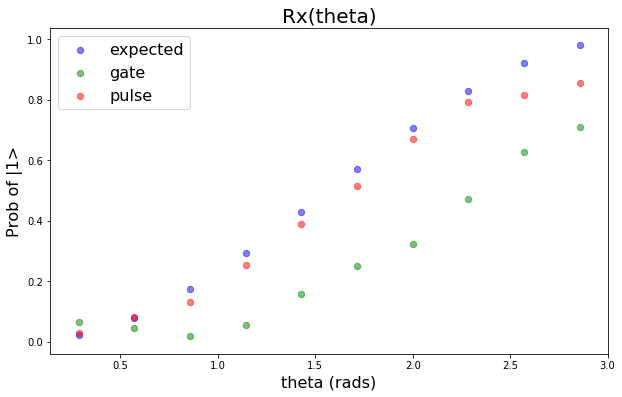

In [25]:
plt.figure(figsize=(10,6))
plt.title('Rx(theta)', fontsize=20)
plt.xlabel('theta (rads)', fontsize=16)
plt.ylabel('Prob of |1>', fontsize=16)
plt.scatter(angles, expected_1_fracs,
            s=40, cmap='viridis',c='blue',alpha=0.5, label='expected')
plt.scatter(angles, gate_1_fracs,
            s=40, cmap='viridis',c='green',alpha=0.5, label='gate')
plt.scatter(angles, pulse_1_fracs,
            s=40, cmap='viridis',c='red',alpha=0.5, label='pulse')
plt.legend(loc='upper left', fontsize=16)
plt.show()